# **THIS NOTEBOOK**: a pedagogical implementation of the neural network from Nielsen's online textbook, [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html), for recognizing handwritten digits using the MNIST dataset.

Created by Spencer Hill July 2025

# Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr

# Load the MNIST data

In [3]:
import mnist_loader
mnist_data_in = mnist_loader.load_data()
training_data = mnist_data_in[0]
validation_data = mnist_data_in[1]
test_data = mnist_data_in[2]

In [4]:
[print(d.shape) for d in training_data]

(50000, 784)
(50000,)


[None, None]

In [5]:
[print(d.shape) for d in test_data]

(10000, 784)
(10000,)


[None, None]

In [6]:
[print(d.shape) for d in validation_data]

(10000, 784)
(10000,)


[None, None]

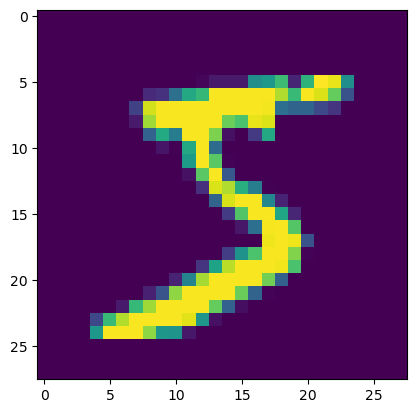

In [7]:
plt.imshow(training_data[0][0].reshape(28, 28))

In [8]:
training_data[1][0]

5

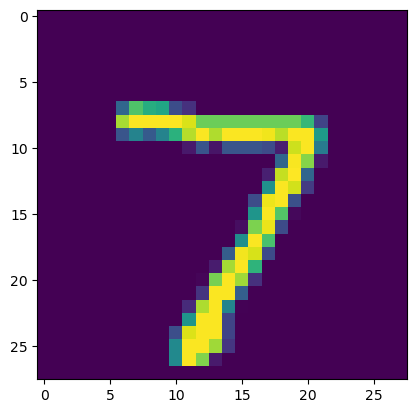

In [9]:
plt.imshow(test_data[0][0].reshape(28, 28))

In [10]:
test_data[1][0]

7

# Create the NN

In [11]:
class NeuralNet:
    def __init__(self, neurons_per_layer, rng_seed=None):
        """Pedagogical implementation of Nielsen's neural network for handwritten digit recognition.

        Biases: each neuron has a single bias.
        Weights: each neuron has a weight for each of its inputs.  The input layer doesn't have any weights,
        since each "neuron" in that layer takes just a single input, unweighted.

        """
        self._num_layers = len(neurons_per_layer)                                                                               
        self._n_per_layer = np.array(neurons_per_layer)
        
        # Set the weights matrix and biases for each layer after the input layer.  They are not defined
        # for the first layer, but to simplify the indexing add a dummy "None" value as
        # the first layer.
        rng = np.random.default_rng(seed=rng_seed)
        self._bias = [None] + [rng.normal(scale=0.1, size=num_neurons) 
                               for num_neurons in self._n_per_layer[1:]]
        self._weight = [None] + [
            rng.normal(scale=0.1, size=(self._n_per_layer[l], self._n_per_layer[l - 1]))
            for l in range(1, self._num_layers)]

    @staticmethod
    def _compute_zl(weights_l, activation_lm1, bias_l):
        """Compute the weighted inputs z^l = w^l * a^{l-1} + b^l for each neuron in the given layer l."""
        wl_alm1 = np.matmul(weights_l[np.newaxis,:,:], activation_lm1[:,:,np.newaxis]).squeeze()
        return wl_alm1 + bias_l[np.newaxis,:]

    @staticmethod
    def _act_func(zl):
        """Activation function, currently sigmoid."""
        return scipy.special.expit(zl)

    @staticmethod
    def _da_dz(zl):
        """Derivative of the activation function (currently sigmoid) w/r/t its input."""
        return scipy.special.expit(zl) * (1 - scipy.special.expit(zl))

    @staticmethod
    def _desired_as_array(arr):
        """Return a 10-dimensional unit vector with a 1.0 in the jth
        position and zeroes elsewhere.  This is used to convert a digit
        (0...9) into a corresponding desired output from the neural
        network.
        
        Adapted from Nielsen's function.
        """
        out = np.zeros((len(arr), 10))
        for j, element in enumerate(arr):
            out[j,element] = 1.0
        return out

    def stoch_grad_descent(
        self, 
        training_data,
        training_desired_output,
        batch_size=10,
        num_epochs=10,
        learning_rate=3.0,
        test_data=None, 
        test_desired_output=None,   
        rng_seed=None,
    ):
        """Stochastic gradient descent training."""
        num_batches = int(np.ceil(training_data.shape[0] / batch_size))
        # Loop over all epochs
        for n, epoch in enumerate(range(num_epochs)):
            # Evalute the model's performance if test data is provided.
            # TODO: encapsulate this logic into its own method.
            if test_data is not None:
                output_raw = self.feed_forward(test_data)
                output = np.argmax(output_raw, axis=1)
                is_correct = output == test_desired_output
                frac_correct = is_correct.sum() / len(output)
                print(f"Epoch #{n}: {is_correct.sum()} / {len(output)} = {frac_correct:0.2f}")

            # Randomly shuffle the training data and desired output.
            data_train = training_data.copy()
            desired_output = training_desired_output.copy()
            if rng_seed is None:
                rng_seed = np.random.default_rng().integers(0, 2**32, size=1)[0]
            rng_train = np.random.default_rng(seed=rng_seed)
            rng_train.shuffle(data_train, axis=0)
            rng_desired = np.random.default_rng(seed=rng_seed)
            rng_desired.shuffle(desired_output, axis=0)
            
            # Loop over all mini batches.
            for m in range(num_batches):
                # Grab the random subset for this mini batch.
                data_train_mb = data_train[m * batch_size: (m + 1) * batch_size]
                desired_out_mb = self._desired_as_array(
                    desired_output[m * batch_size: (m + 1) * batch_size].flatten())
                # Initialize the error, activation, and z_l arrays
                errors = [None] + [
                    np.full((data_train_mb.shape[0], num_neurons), np.nan)
                    for num_neurons in self._n_per_layer[1:]
                ]
                activation = [
                    np.full((data_train_mb.shape[0], num_neurons), np.nan)
                    for num_neurons in self._n_per_layer
                ] 
                zl = [None] + [
                    np.full((data_train_mb.shape[0], num_neurons), np.nan)
                    for num_neurons in self._n_per_layer[1:]
                ]

                # Apply feedforward for each training input.
                activation[0] = data_train_mb
                for layer in range(1, self._num_layers):
                    # Compute activation of each layer
                    zl[layer] = self._compute_zl(
                        self._weight[layer], 
                        activation[layer - 1], 
                        self._bias[layer],
                    )
                    activation[layer] = self._act_func(zl[layer])

                # Backpropagation.
                # Compute error of last layer.
                dcost_dact_last = activation[-1] - desired_out_mb
                errors[-1] = dcost_dact_last * self._da_dz(zl[-1])

                # Compute errors of earlier layers from subsequent layers.
                for layer in range(self._num_layers - 2, 0, -1):
                    errors[layer] = np.matmul(
                        self._weight[layer+1].transpose()[np.newaxis,:,:],
                        errors[layer + 1][:,:,np.newaxis]).squeeze() * self._da_dz(zl[layer])
        
                # Update the weights and biases.
                for layer in range(self._num_layers - 1, 0, -1):
                    # Compute the bias and weight increments for each training input.
                    bias_inc = errors[layer].mean(axis=0)
                    weight_inc = np.matmul(
                        errors[layer][:,:,np.newaxis], 
                        activation[layer - 1][:,np.newaxis,:],
                    ).mean(axis=0)
                    # Apply the increments.
                    self._bias[layer] = self._bias[layer] - learning_rate * bias_inc
                    self._weight[layer] = self._weight[layer] - learning_rate * weight_inc
                

    def feed_forward(self, inputs):
        """Run the NN for the given inputs."""
        activation = inputs
        for layer in range(1, self._num_layers):
            z = self._compute_zl(self._weight[layer], activation, self._bias[layer])
            activation = self._act_func(z)
        return activation
        

# Train and test the NN

In [12]:
nn = NeuralNet([784, 30, 10], rng_seed=None)
nn.stoch_grad_descent(
    training_data=training_data[0],
    training_desired_output=training_data[1],
    num_epochs=30, 
    batch_size=100,
    learning_rate=5,
    test_data=test_data[0], 
    test_desired_output=test_data[1], 
    rng_seed=None,
)

Epoch #0: 1020 / 10000 = 0.10
Epoch #1: 9165 / 10000 = 0.92
Epoch #2: 9308 / 10000 = 0.93
Epoch #3: 9376 / 10000 = 0.94
Epoch #4: 9413 / 10000 = 0.94
Epoch #5: 9431 / 10000 = 0.94
Epoch #6: 9464 / 10000 = 0.95
Epoch #7: 9491 / 10000 = 0.95
Epoch #8: 9513 / 10000 = 0.95
Epoch #9: 9529 / 10000 = 0.95
Epoch #10: 9535 / 10000 = 0.95
Epoch #11: 9537 / 10000 = 0.95
Epoch #12: 9547 / 10000 = 0.95
Epoch #13: 9552 / 10000 = 0.96
Epoch #14: 9558 / 10000 = 0.96
Epoch #15: 9561 / 10000 = 0.96
Epoch #16: 9563 / 10000 = 0.96
Epoch #17: 9564 / 10000 = 0.96
Epoch #18: 9562 / 10000 = 0.96
Epoch #19: 9563 / 10000 = 0.96
Epoch #20: 9567 / 10000 = 0.96
Epoch #21: 9568 / 10000 = 0.96
Epoch #22: 9572 / 10000 = 0.96
Epoch #23: 9571 / 10000 = 0.96
Epoch #24: 9569 / 10000 = 0.96
Epoch #25: 9573 / 10000 = 0.96
Epoch #26: 9573 / 10000 = 0.96
Epoch #27: 9572 / 10000 = 0.96
Epoch #28: 9572 / 10000 = 0.96
Epoch #29: 9579 / 10000 = 0.96
